# GOOGLE DRIVE

In [ ]:
!gdown --id 1ORqSfvllaxTsfBX0g_YU9lpF3kTxYzMv

In [ ]:
!gdown --id 1Q0Am8SP-kJL5Fv8ZurIiXSkmz86knhf3
!unzip data.zip -d ./data
!rm data.zip

# SETTINGS

In [ ]:
import os
import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from bs4 import BeautifulSoup

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

import gensim

RANDOM_STATE = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# DATA

Объем данных составляет 50К, по положительным-отрицательным разделены поровну, по оценке они достаточно несбалансированы. Для модели разделим в долях по 70%-30%, обучение-тест соответсвенно. Словарь был взят из предоставленных данных.

* Для оценки качества, модели определяющей настроение, будем использовать accuracy, так как данные сбалансированы.

* Для оценки качества, модели предсказывающей оценку, будем использовать mean absolute error, так как эта метрика хорошо интерпретируется на то как юзер будет использовать модель.

## Load Data

In [ ]:
with open('imdb_vocab.txt', 'r') as f:
  vocab = f.read().splitlines()

количество текстов в выборке 50000
распределение по положительным и отрицательным


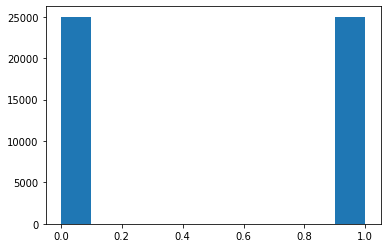

распределение по оценке


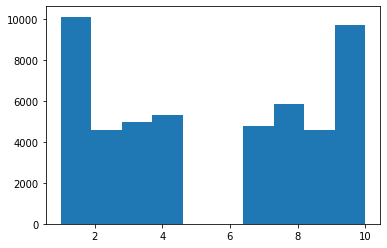

In [ ]:
data_paths = ['./data/train/neg/', './data/test/neg/', './data/train/pos/', './data/test/pos/']
sentences, score = [], []
stopwords_list = nltk.corpus.stopwords.words("english")
le = nltk.stem.WordNetLemmatizer()

for i, path in enumerate(data_paths):
  for f_name in os.listdir(path):
    score.append(int(f_name.split('_')[1].replace('.txt', '')))
    with open(path + f_name, 'r') as f:
      text = BeautifulSoup(f.read(), "lxml").get_text()
      text = re.sub('[^a-zA-Z0-9]', ' ', text.lower().strip()).split()
      text = [le.lemmatize(word) for word in text if word not in stopwords_list and len(word) > 3]
      sentences.append(' '.join(text))

df = pd.DataFrame({'sentences': sentences, 'score': score})

print('количество текстов в выборке', len(df))
print('распределение по положительным и отрицательным')
labels = [0 if s < 5 else 1 for s in df['score']]
plt.hist(labels)
plt.show()
print('распределение по оценке')
plt.hist(df['score'], bins=10)
plt.show()

In [ ]:
train_ind, test_ind = train_test_split(range(len(df)), test_size=0.3, random_state=RANDOM_STATE)

y_train_score = df['score'][train_ind].values
y_test_score = df['score'][test_ind].values

y_train_sent = np.array(labels)[train_ind]
y_test_sent = np.array(labels)[test_ind]

# MODELS

В данной работе были использованы две модели.

* Bag of Words с правилом векторизации TF-IDF, для предсказания были использованы модели машинного обучения
 * Для оценки настроения рецензии с использованием линейного классификатора точность составляет 89%
 * Для предсказания оценки рецензии, линейный классификатор дал MAE=1.43, результат линейной регрессивной модели составляет MAE=1.64. Если усреднить результаты двух моделей то можно уменьшить ошибку до MAE=1.38 (меньше на ~3.5%)

* Word2Vec, для предсказания была использована рекуррентная нейросеть.
 * Для оценки настроения рецензии точность составляет 87%
 * Для предсказания оценки рецензии MAE=1.46. Если усреднить результаты всех моделей то можно уменьшить ошибку до MAE=1.29 (что еще меньше на ~7.5%)

## Bag of Words TF-IDF

### vectors

In [ ]:
vect = TfidfVectorizer(vocabulary=vocab, max_df=0.8, min_df=4)

x_train_bag = vect.fit_transform(df['sentences'][train_ind].values)
x_test_bag = vect.fit_transform(df['sentences'][test_ind].values)

### model method

In [ ]:
def machine_train(estimators, x_train, y_train, x_test, y_test, mode='clf'):
  model_arr = []
  pred_arr = []
  for i, est in enumerate(estimators):
    est.fit(x_train, y_train)
    model_arr.append(est)
    
    pred_train = est.predict(x_train)
    pred_test = est.predict(x_test)
    
    if mode == 'clf':
      print('результаты тренировочной выборки', '\n', classification_report(y_train, pred_train))
      print('\nрезультаты тестовой выборки', '\n', classification_report(y_test, pred_test))
    
    elif mode == 'reg':
      pred_train = [1 if pred < 1 else (10 if pred > 10 else pred) for pred in pred_train]
      pred_test = [1 if pred < 1 else (10 if pred > 10 else pred) for pred in pred_test]
      print(f'средняя абсолютная ошибка тренировочной выборки ({i})', mean_absolute_error(pred_train, y_train))
      print(f'средняя абсолютная ошибка тестовой выборки ({i})     ', mean_absolute_error(pred_test, y_test), '\n')
  
    pred_arr.append(pred_test)
  return model_arr, pred_arr

### sentiment prediction

In [ ]:
print('Bag of Words TF-IDF')
model_arr, pred_arr = machine_train([LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)],
                                    x_train_bag, y_train_sent, x_test_bag, y_test_sent)

with open("machine_models_sent.pckl", "wb") as f:
  for model in model_arr:
    pickle.dump(model, f)

Bag of Words TF-IDF
результаты тренировочной выборки 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     17474
           1       0.92      0.94      0.93     17526

    accuracy                           0.93     35000
   macro avg       0.93      0.93      0.93     35000
weighted avg       0.93      0.93      0.93     35000


результаты тестовой выборки 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      7526
           1       0.88      0.90      0.89      7474

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



### score prediction

In [ ]:
print('Bag of Words TF-IDF')
model_arr, pred_score_arr = machine_train([LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                                           Ridge(random_state=RANDOM_STATE)],
                                          x_train_bag, y_train_score, x_test_bag, y_test_score, mode='reg')

print('общая средняя абсолютная ошибка: ', mean_absolute_error(np.median(pred_score_arr, axis=0), y_test_score))

with open("machine_models_score.pckl", "wb") as f:
  for model in model_arr:
    pickle.dump(model, f)

Bag of Words TF-IDF
средняя абсолютная ошибка тренировочной выборки (0) 0.8165714285714286
средняя абсолютная ошибка тестовой выборки (0)      1.4276 

средняя абсолютная ошибка тренировочной выборки (1) 1.2142767691114251
средняя абсолютная ошибка тестовой выборки (1)      1.6371351672361605 

общая средняя абсолютная ошибка:  1.3795868464530552


## Word Embedding Word2Vec

### vectors

In [ ]:
sentences = []
for text in df['sentences']:
  sentences.append(text.split())

In [ ]:
w2v_model = gensim.models.Word2Vec(sentences, size=300, window=5, min_count=10)
w2v_model.save('word2vec.model')

In [ ]:
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
print(f'Vocabulary Size: {vocab_size} - Embedding Dim: {embedding_size}')

Vocabulary Size: 24034 - Embedding Dim: 300


In [ ]:
MAX_SEQUENCE_LENGTH = 200
corpus = []

for sentence in sentences:
  sentence_vect = []
  for word in sentence[:MAX_SEQUENCE_LENGTH]:
    try: sentence_vect.append(w2v_model.wv.vocab[word].index)
    except: sentence_vect.append(0)
  corpus.append(sentence_vect)

corpus = pad_sequences(corpus, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)

In [ ]:
x_train_w2v = corpus[train_ind]
x_test_w2v = corpus[test_ind]

### model overall

In [ ]:
EPOCHS     = 20
BATCH_SIZE = 512

### sentiment prediction

In [ ]:
CATEGORIES_SENT = 2

In [ ]:
model_sent = Sequential()

model_sent.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        weights=[w2v_weights],
                        input_length=MAX_SEQUENCE_LENGTH,
                        mask_zero=True,
                        trainable=False))
model_sent.add(Bidirectional(LSTM(100)))
model_sent.add(Dense(32, activation='relu'))
model_sent.add(Dropout(0.2))
model_sent.add(Dense(CATEGORIES_SENT, activation='softmax'))

In [ ]:
model_sent.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_sent.hdf5', monitor=['val_loss'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks_list_sent = [checkpoint, earlystop]

In [ ]:
history = model_sent.fit(x_train_w2v,
                         y_train_sent,
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test_w2v, y_test_sent),
                         callbacks = callbacks_list_sent,
                         verbose=1)

model_sent.save('best_model_sent.hdf5')
model_sent.load_weights('best_model_sent.hdf5')

!rm model_sent.hdf5

Epoch 1/20
69/69 [==============================] - 171s 2s/step - loss: 0.4389 - accuracy: 0.7908 - val_loss: 0.3465 - val_accuracy: 0.8489

Epoch 00001: saving model to model_sent.hdf5
Epoch 2/20
69/69 [==============================] - 107s 2s/step - loss: 0.3341 - accuracy: 0.8563 - val_loss: 0.3584 - val_accuracy: 0.8423

Epoch 00002: saving model to model_sent.hdf5
Epoch 3/20
69/69 [==============================] - 107s 2s/step - loss: 0.2938 - accuracy: 0.8765 - val_loss: 0.3121 - val_accuracy: 0.8681

Epoch 00003: saving model to model_sent.hdf5
Epoch 4/20
69/69 [==============================] - 109s 2s/step - loss: 0.2724 - accuracy: 0.8851 - val_loss: 0.3054 - val_accuracy: 0.8711

Epoch 00004: saving model to model_sent.hdf5
Epoch 5/20
69/69 [==============================] - 106s 2s/step - loss: 0.2506 - accuracy: 0.8954 - val_loss: 0.3063 - val_accuracy: 0.8742

Epoch 00005: saving model to model_sent.hdf5
Epoch 6/20
69/69 [==============================] - 107s 2s/step 

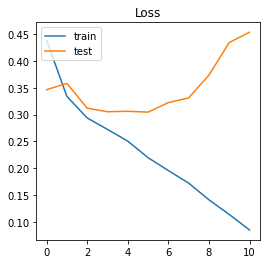

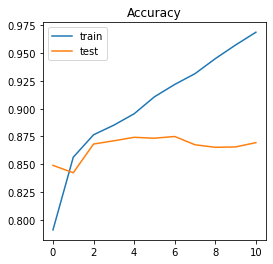

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pred_w2v = model_sent.predict(x_test_w2v, verbose=1)
pred_w2v = np.argmax(pred_w2v, axis=-1)

print('результаты тестовой выборки', '\n', classification_report(y_test_sent, pred_w2v))

469/469 [==============================] - 73s 150ms/step
результаты тестовой выборки 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      7526
           1       0.87      0.88      0.87      7474

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



### score prediction

In [ ]:
CATEGORIES_SCORE = 8

category_dict = {k: v for v, k in enumerate(np.unique(df['score']))}
category_dict_rev = {k: v for k, v in enumerate(np.unique(df['score']))}

y_train_w2v = np.array([category_dict[y] for y in y_train_score])
y_test_w2v = np.array([category_dict[y] for y in y_test_score])

In [ ]:
model_score = Sequential()

model_score.add(Embedding(input_dim=vocab_size,
                          output_dim=embedding_size,
                          weights=[w2v_weights],
                          input_length=MAX_SEQUENCE_LENGTH,
                          mask_zero=True,
                          trainable=False))
model_score.add(Bidirectional(LSTM(100)))
model_score.add(Dense(32, activation='relu'))
model_score.add(Dropout(0.2))
model_score.add(Dense(CATEGORIES_SCORE, activation='softmax'))

In [ ]:
model_score.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_score.hdf5', monitor=['val_loss'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks_list_score = [checkpoint, earlystop]

In [ ]:
history = model_score.fit(x_train_w2v,
                          y_train_w2v,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(x_test_w2v, y_test_w2v),
                          callbacks = callbacks_list_score,
                          verbose=1)

model_score.save('best_model_score.hdf5')
model_score.load_weights('best_model_score.hdf5')

!rm model_score.hdf5

Epoch 1/20
69/69 [==============================] - 116s 2s/step - loss: 1.7878 - accuracy: 0.3257 - val_loss: 1.5775 - val_accuracy: 0.3988

Epoch 00001: saving model to model_score.hdf5
Epoch 2/20
69/69 [==============================] - 104s 2s/step - loss: 1.5719 - accuracy: 0.3960 - val_loss: 1.5246 - val_accuracy: 0.4087

Epoch 00002: saving model to model_score.hdf5
Epoch 3/20
69/69 [==============================] - 106s 2s/step - loss: 1.5045 - accuracy: 0.4165 - val_loss: 1.5019 - val_accuracy: 0.4162

Epoch 00003: saving model to model_score.hdf5
Epoch 4/20
69/69 [==============================] - 104s 2s/step - loss: 1.4535 - accuracy: 0.4345 - val_loss: 1.4831 - val_accuracy: 0.4197

Epoch 00004: saving model to model_score.hdf5
Epoch 5/20
69/69 [==============================] - 106s 2s/step - loss: 1.4113 - accuracy: 0.4477 - val_loss: 1.4819 - val_accuracy: 0.4224

Epoch 00005: saving model to model_score.hdf5
Epoch 6/20
69/69 [==============================] - 108s 2s/

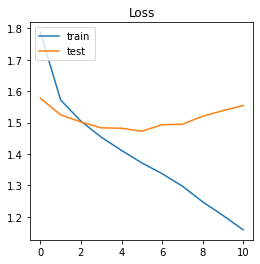

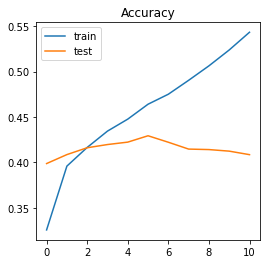

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pred_w2v = model_score.predict(x_test_w2v, verbose=1)
pred_w2v = np.argmax(pred_w2v, axis=-1)
pred_w2v = [category_dict_rev[pred] for pred in pred_w2v]
print('средняя абсолютная ошибка на тесте: ', mean_absolute_error(pred_w2v, y_test_score))

pred_final = [*pred_score_arr, pred_w2v]
pred_final = np.median(pred_final, axis=0)

print('финальная средняя абсолютная ошибка на тесте: ', mean_absolute_error(pred_final, y_test_score))

469/469 [==============================] - 72s 149ms/step
средняя абсолютная ошибка на тесте:  1.4552666666666667
финальная средняя абсолютная ошибка на тесте:  1.2882657851276642
